In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

!pip install -q git+https://github.com/RobertTLange/evosax.git@main
!pip install -q gymnax

You should consider upgrading via the '/Users/chatt07/Desktop/readout_env/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/chatt07/Desktop/readout_env/bin/python3 -m pip install --upgrade pip' command.


In [2]:
import jax
import jax.numpy as jnp

from evosax import OpenES, ParameterReshaper, FitnessShaper, NetworkMapper
from evosax.utils import ESLog
from evosax.problems import GymnaxFitness

rng = jax.random.PRNGKey(0)
network = NetworkMapper["MLP"](
    num_hidden_units=64,
    num_hidden_layers=2,
    num_output_units=2,
    hidden_activation="relu",
    output_activation="categorical",
)
pholder = jnp.zeros((4,))
params = network.init(
    rng,
    x=pholder,
    rng=rng,
)

param_reshaper = ParameterReshaper(params)

ParameterReshaper: 4610 parameters detected for optimization.


In [3]:
evaluator = GymnaxFitness("CartPole-v1", num_env_steps=200, num_rollouts=16)
evaluator.set_apply_fn(network.apply)

In [4]:
strategy = OpenES(popsize=100,
                num_dims=param_reshaper.total_params,
                opt_name="adam",
                lrate_init=0.1)
strategy.default_params

EvoParams(opt_params=OptParams(lrate_init=0.1, lrate_decay=1.0, lrate_limit=0.001, momentum=None, beta_1=0.99, beta_2=0.999, beta_3=None, eps=1e-08, max_speed=None), sigma_init=0.03, sigma_decay=1.0, sigma_limit=0.01, init_min=0.0, init_max=0.0, clip_min=-3.4028235e+38, clip_max=3.4028235e+38)

In [5]:
num_generations = 100
print_every_k_gens = 20

es_logging = ESLog(param_reshaper.total_params,
                   num_generations=num_generations,
                   top_k=5,
                   maximize=True)
log = es_logging.initialize()

fit_shaper = FitnessShaper(centered_rank=True,
                           w_decay=0.0,
                           maximize=True)

state = strategy.initialize(rng)

for gen in range(num_generations):
    rng, rng_init, rng_ask, rng_eval = jax.random.split(rng, 4)
    x, state = strategy.ask(rng_ask, state)
    reshaped_params = param_reshaper.reshape(x)
    fitness = evaluator.rollout(rng_eval, reshaped_params).mean(axis=1)
    fit_re = fit_shaper.apply(x, fitness)
    state = strategy.tell(x, fit_re, state)
    log = es_logging.update(log, x, fitness)
    
    if gen % print_every_k_gens == 0:
        print("Generation: ", gen, "Performance: ", log["log_top_1"][gen])

Generation:  0 Performance:  22.875
Generation:  20 Performance:  200.0
Generation:  40 Performance:  200.0
Generation:  60 Performance:  200.0
Generation:  80 Performance:  200.0


(<Figure size 600x300 with 1 Axes>,
 <Axes: title={'center': 'CartPole MLP OpenAI-ES'}, xlabel='Number of Generations', ylabel='Fitness Score'>)

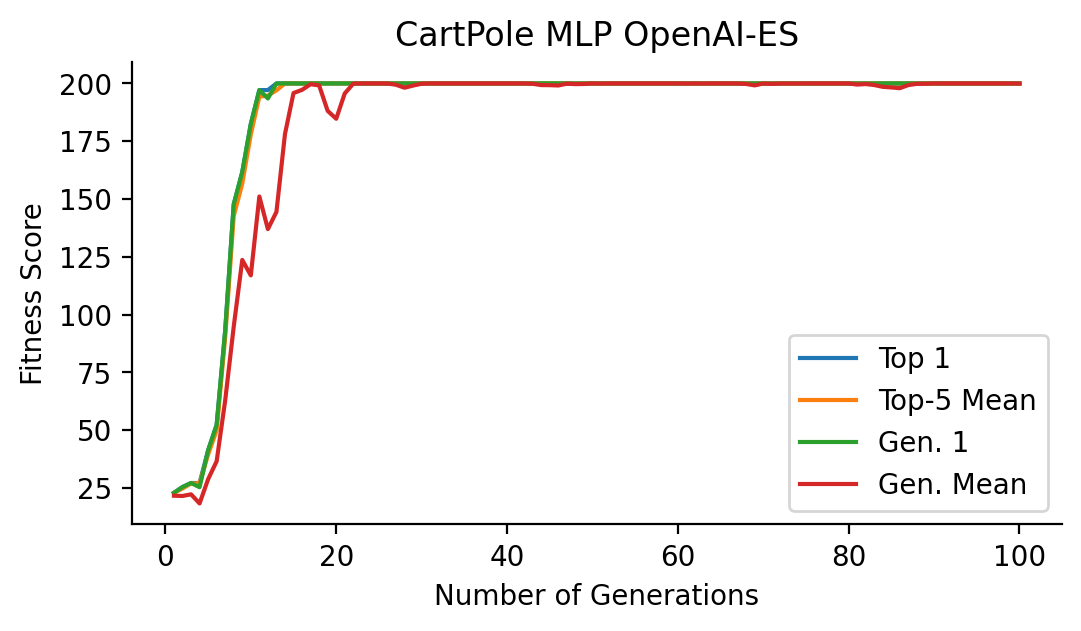

In [6]:
es_logging.plot(log, "CartPole MLP OpenAI-ES")